In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

# Загружаем данные 
file_path = '/Users/hamrozkosimov/Desktop/zypl/Analytics_Project#1-2.xlsx'
df = pd.read_excel(file_path)

# Проверяем названия колонок
print("Колонки в датасете:", df.columns)

# Удаляем колонку "Ссылка"
if 'Ссылка' in df.columns:
    df = df.drop(columns=['Ссылка'])

# Очищаем данные от пустых строк
df = df.dropna()  

# One-Hot Encoding для категориальных признаков
categorical_cols = ['Регион', 'Состояние']  
ohe = OneHotEncoder(sparse_output=False, drop='first')
encoded_features = pd.DataFrame(ohe.fit_transform(df[categorical_cols]), columns=ohe.get_feature_names_out(categorical_cols))

# Добавляем закодированные признаки в датасет
df = df.drop(columns=categorical_cols)
df = pd.concat([df, encoded_features], axis=1)

# Определяем целевую переменную (цена)
X = df.drop(columns=['Цена'])  
y = df['Цена']  

# Разделяем данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Масштабируем данные для модели KNN
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Pairplot для нескольких признаков
if 'Площадь' in df.columns and 'Число комнат' in df.columns:
    plt.figure(figsize=(10, 6))
    sns.pairplot(df[['Цена', 'Площадь', 'Число комнат']])
    plt.show()
else:
    print("Колонки 'Площадь' или 'Число комнат' не найдены. Пропускаем pairplot.")

# Модели для обучения
models = {
    'LinearRegression': LinearRegression(),
    'DecisionTreeRegressor': DecisionTreeRegressor(),
    'RandomForestRegressor': RandomForestRegressor(),
    'GradientBoostingRegressor': GradientBoostingRegressor(),
    'KNN': KNeighborsRegressor()
}

# Функция для оценки моделей
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    results = {
        'MAE_train': mean_absolute_error(y_train, y_pred_train),
        'MSE_train': mean_squared_error(y_train, y_pred_train),
        'R2_train': r2_score(y_train, y_pred_train),
        'MAPE_train': mean_absolute_percentage_error(y_train, y_pred_train),
        'MAE_test': mean_absolute_error(y_test, y_pred_test),
        'MSE_test': mean_squared_error(y_test, y_pred_test),
        'R2_test': r2_score(y_test, y_pred_test),
        'MAPE_test': mean_absolute_percentage_error(y_test, y_pred_test),
    }
    
    return results, y_pred_test

import pickle

# Оценка моделей
model_results = {}
predictions = {}
for name, model in models.items():
    print(f"Обучаем модель: {name}")
    results, y_pred_test = evaluate_model(model, X_train_scaled, X_test_scaled, y_train, y_test)
    model_results[name] = results
    predictions[name] = y_pred_test
    pickle.dump(model, open(f'{name}.pkl','wb'))

# Кросс-валидация для сравнения моделей
def cross_val(model, X, y):
    scores = cross_val_score(model, X, y, cv=5, scoring='neg_root_mean_squared_error')
    return np.mean(-scores)

# Важность признаков для деревьев решений и их ансамблей
def plot_feature_importance(model, X, title):
    feature_importances = model.feature_importances_
    features = X.columns
    importance_df = pd.DataFrame({'Признак': features, 'Важность': feature_importances})
    importance_df = importance_df.sort_values(by='Важность', ascending=False)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Важность', y='Признак', data=importance_df)
    plt.title(title)
    plt.tight_layout()
    plt.show()


# Функция для графика "фактическое против предсказанного"
def plot_actual_vs_predicted(y_test, y_pred, model_name):
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, edgecolor='k', alpha=0.7)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.title(f'Фактическое против предсказанного: {model_name}')
    plt.xlabel('Фактическая цена')
    plt.ylabel('Предсказанная цена')
    plt.tight_layout()
    plt.show()


Колонки в датасете: Index(['Ссылка', 'Цена', 'Регион', 'Количество комнат', 'Площадь', 'Этаж',
       'Состояние'],
      dtype='object')
Колонки 'Площадь' или 'Число комнат' не найдены. Пропускаем pairplot.
Обучаем модель: LinearRegression
Обучаем модель: DecisionTreeRegressor
Обучаем модель: RandomForestRegressor
Обучаем модель: GradientBoostingRegressor
Обучаем модель: KNN


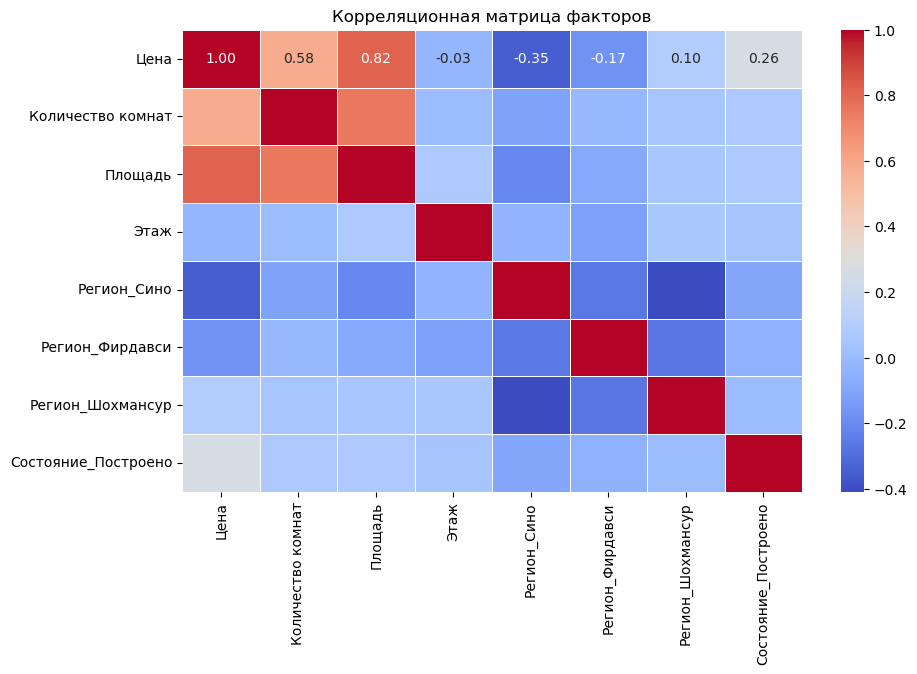

In [2]:
# Тепловая карта корреляции
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Корреляционная матрица факторов')
plt.show()


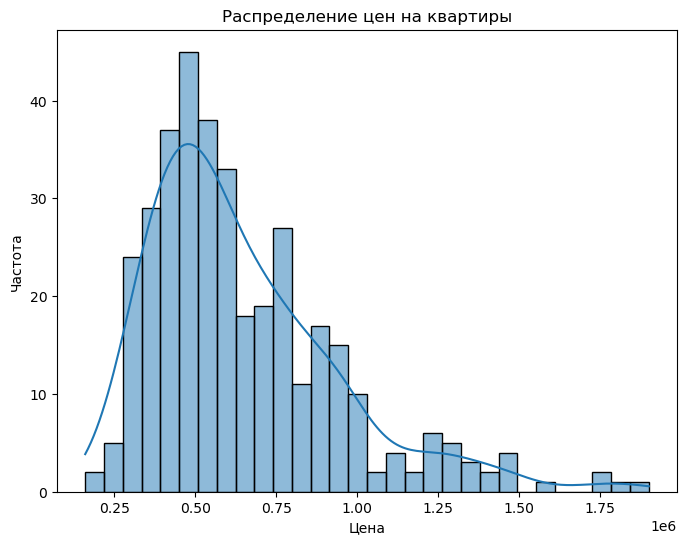

In [3]:
# Распределение целевой переменной (цены)
plt.figure(figsize=(8, 6))
sns.histplot(y, bins=30, kde=True)
plt.title('Распределение цен на квартиры')
plt.xlabel('Цена')
plt.ylabel('Частота')
plt.show()

In [4]:
# Выводим результаты для каждой модели
for name, result in model_results.items():
    print(f"Модель: {name}")
    print(f"Обучающая выборка: MAE: {result['MAE_train']}, MSE: {result['MSE_train']}, R²: {result['R2_train']}, MAPE: {results['MAPE_train']}")
    print(f"Тестовая выборка: MAE: {result['MAE_test']}, MSE: {result['MSE_test']}, R²: {result['R2_test']}, MAPE: {results['MAPE_test']}")
    print("----------------------------------------")


Модель: LinearRegression
Обучающая выборка: MAE: 103403.44595619831, MSE: 20548651984.95718, R²: 0.7783217690130126, MAPE: 0.15962135607327152
Тестовая выборка: MAE: 89583.69120189104, MSE: 13525136772.584257, R²: 0.8022951836213913, MAPE: 0.18719994191839662
----------------------------------------
Модель: DecisionTreeRegressor
Обучающая выборка: MAE: 580.8758620689655, MSE: 16486182.95862069, R²: 0.999822147560985, MAPE: 0.15962135607327152
Тестовая выборка: MAE: 112054.3698630137, MSE: 29692400085.27397, R²: 0.56596886187513, MAPE: 0.18719994191839662
----------------------------------------
Модель: RandomForestRegressor
Обучающая выборка: MAE: 41022.36731724138, MSE: 3593660391.541975, R²: 0.9612317012839473, MAPE: 0.15962135607327152
Тестовая выборка: MAE: 103000.01447488584, MSE: 18464310049.281673, R²: 0.730096405734651, MAPE: 0.18719994191839662
----------------------------------------
Модель: GradientBoostingRegressor
Обучающая выборка: MAE: 61958.444784015934, MSE: 7067451019

In [5]:
print("Результаты кросс-валидации:")
for name, model in models.items():
    score = cross_val(model, X_train_scaled, y_train)
    print(f"{name} RMSE кросс-валидации: {score}")

Результаты кросс-валидации:
LinearRegression RMSE кросс-валидации: 148555.1538888134
DecisionTreeRegressor RMSE кросс-валидации: 188259.74910899086
RandomForestRegressor RMSE кросс-валидации: 150436.3486927455
GradientBoostingRegressor RMSE кросс-валидации: 157044.452915006
KNN RMSE кросс-валидации: 166440.75724333903


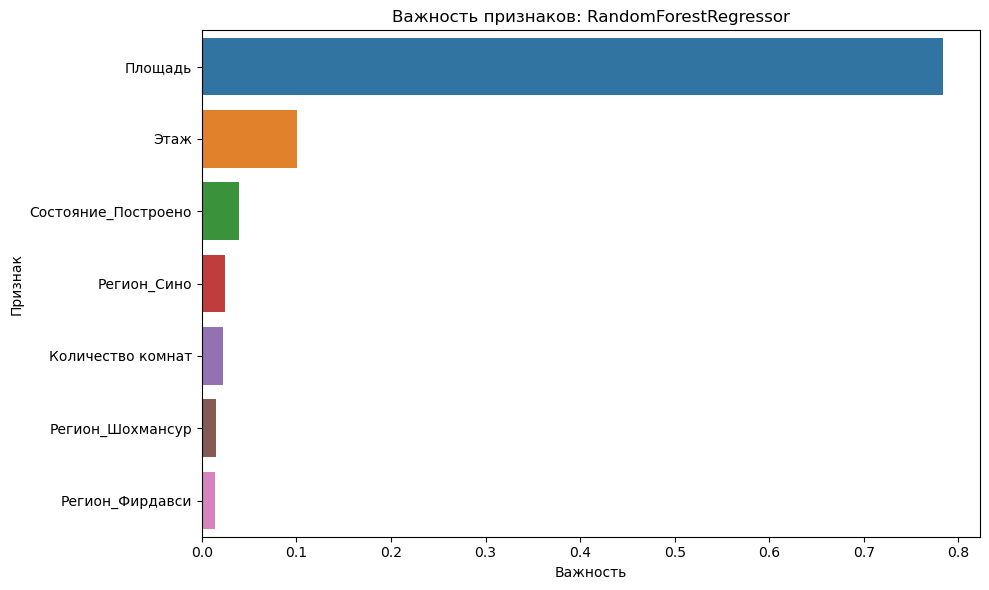

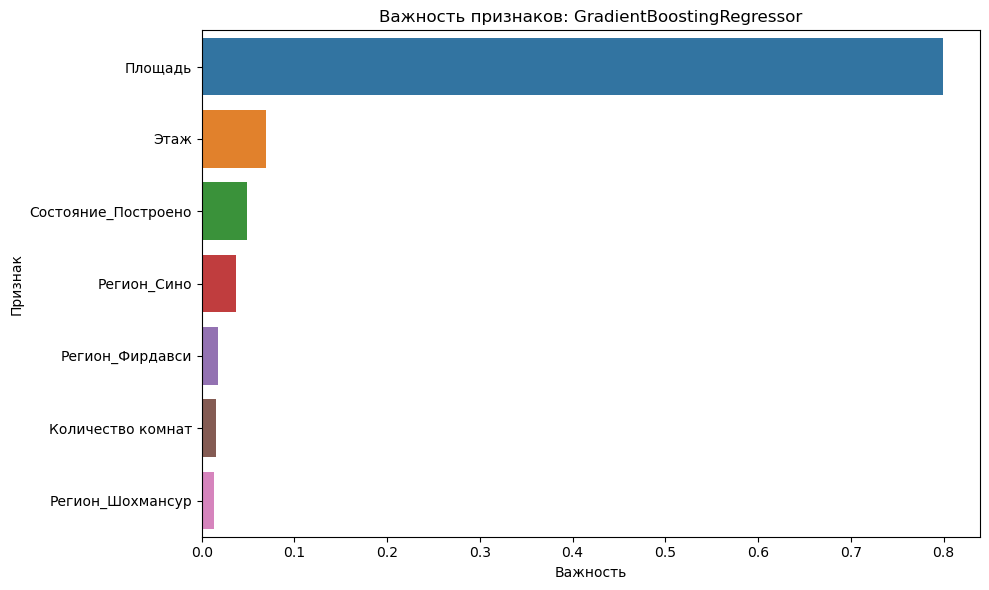

In [6]:
# Графики важности признаков для случайного леса и градиентного бустинга
for name in ['RandomForestRegressor', 'GradientBoostingRegressor']:
    model = models[name]
    if hasattr(model, 'feature_importances_'):
        plot_feature_importance(model, X_train, f'Важность признаков: {name}')

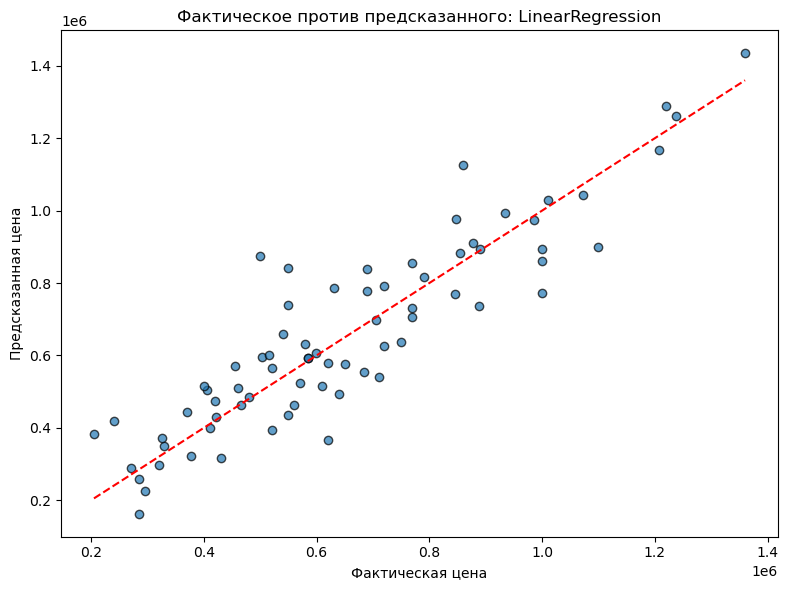

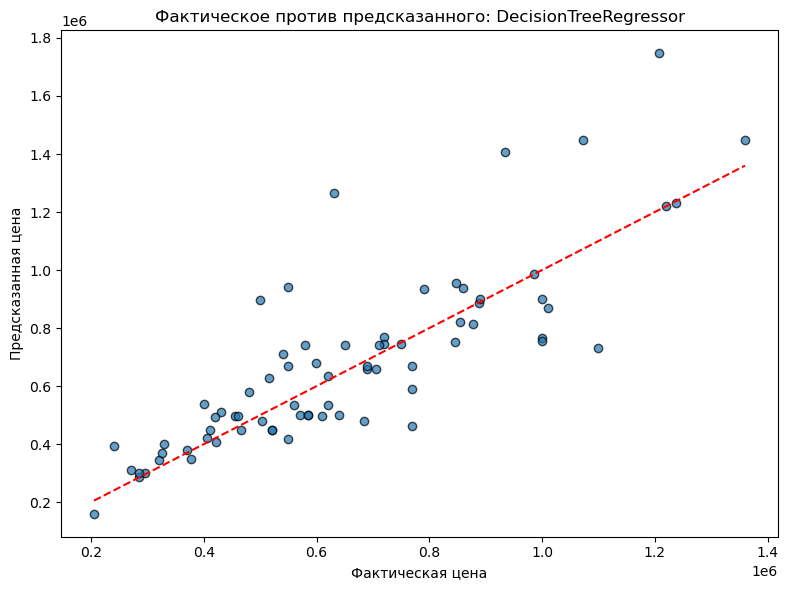

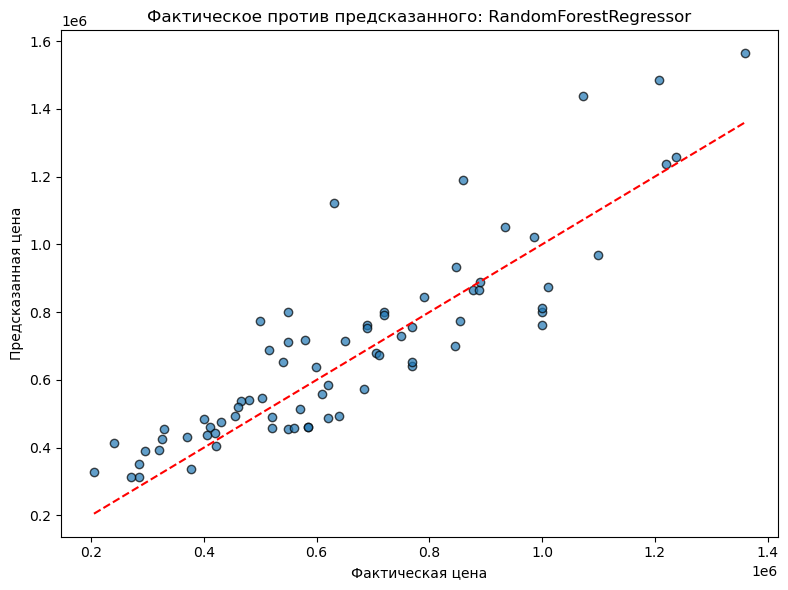

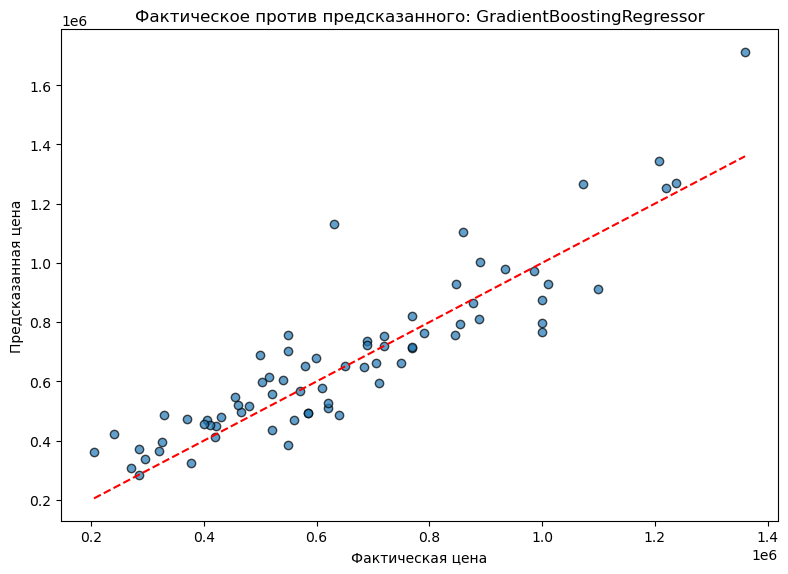

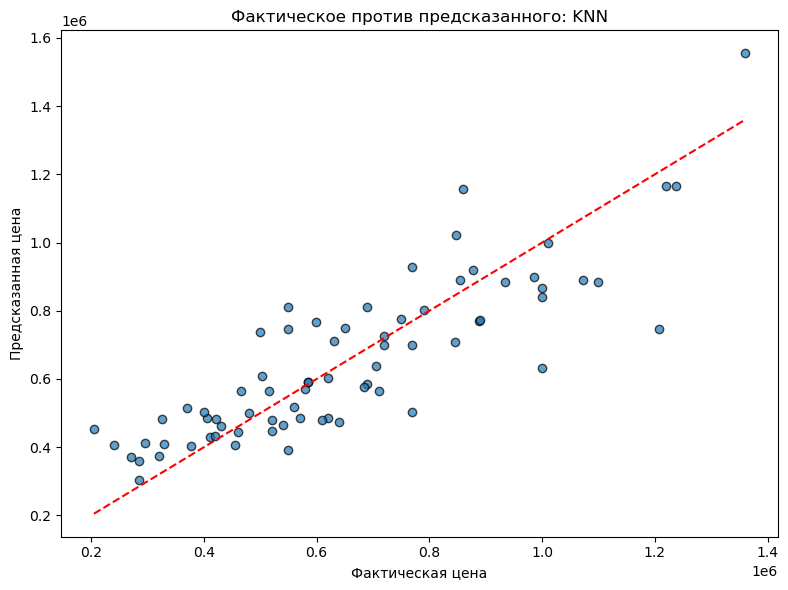

In [7]:
# Построение графиков для каждой модели
for name, y_pred in predictions.items():
    plot_actual_vs_predicted(y_test, y_pred, name)

In [8]:
# Таблица с результатами
model_comparison_df = pd.DataFrame(model_results).T[['MAE_test', 'MSE_test', 'R2_test']]
print(model_comparison_df) 

                                MAE_test      MSE_test   R2_test
LinearRegression            89583.691202  1.352514e+10  0.802295
DecisionTreeRegressor      112054.369863  2.969240e+10  0.565969
RandomForestRegressor      103000.014475  1.846431e+10  0.730096
GradientBoostingRegressor   91846.759511  1.510493e+10  0.779202
KNN                        107196.989041  1.917636e+10  0.719688
